In [ ]:
%pip install -q torch transformers langchain sentence-transformers tqdm openpyxl openai pandas datasets langchain-community ragatouille


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 119.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 125.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.3/303.3 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.9/332.9 k

In [ ]:
from tqdm.auto import tqdm
import pandas as pd
from typing import Optional, List, Tuple
import json
import datasets

pd.set_option("display.max_colwidth", None)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")

README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

huggingface_doc.csv:   0%|          | 0.00/22.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2647 [00:00<?, ? examples/s]

In [ ]:
ds[0]

{'text': ' Create an Endpoint\n\nAfter your first login, you will be directed to the [Endpoint creation page](https://ui.endpoints.huggingface.co/new). As an example, this guide will go through the steps to deploy [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) for text classification. \n\n## 1. Enter the Hugging Face Repository ID and your desired endpoint name:\n\n<img src="https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_repository.png" alt="select repository" />\n\n## 2. Select your Cloud Provider and region. Initially, only AWS will be available as a Cloud Provider with the `us-east-1` and `eu-west-1` regions. We will add Azure soon, and if you need to test Endpoints with other Cloud Providers or regions, please let us know.\n\n<img src="https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_region.png" alt="select region" />\n\n## 3. Defi

In [ ]:
len(ds)

2647

In [ ]:
from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]}) for doc in tqdm(ds)
]

  0%|          | 0/2647 [00:00<?, ?it/s]

In [ ]:
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: str,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of size `chunk_size` characters and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique

In [ ]:
chunks = split_documents(512, RAW_KNOWLEDGE_BASE,"thenlper/gte-small")

In [ ]:
len(chunks)

16776

In [ ]:
chunks[0]

Document(metadata={'source': 'huggingface/hf-endpoints-documentation/blob/main/docs/source/guides/create_endpoint.mdx', 'start_index': 1}, page_content='Create an Endpoint\n\nAfter your first login, you will be directed to the [Endpoint creation page](https://ui.endpoints.huggingface.co/new). As an example, this guide will go through the steps to deploy [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) for text classification. \n\n## 1. Enter the Hugging Face Repository ID and your desired endpoint name:\n\n<img src="https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_repository.png" alt="select repository" />\n\n## 2. Select your Cloud Provider and region. Initially, only AWS will be available as a Cloud Provider with the `us-east-1` and `eu-west-1` regions. We will add Azure soon, and if you need to test Endpoints with other Cloud Providers or regions, please let us know.\n\n<im

In [ ]:
lengths = [len(chunk.page_content) for chunk in chunks]

  0%|          | 0/16776 [00:00<?, ?it/s]

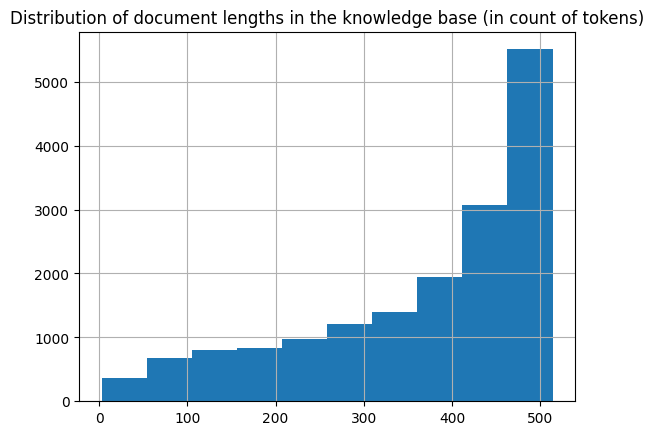

In [ ]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt


tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(chunks)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [ ]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import os


def load_embeddings(
    langchain_docs: List[LangchainDocument],
    chunk_size: int,
    embedding_model_name: Optional[str] = "thenlper/gte-small",
) -> FAISS:
    """
    Creates a FAISS index from the given embedding model and documents. Loads the index directly if it already exists.

    Args:
        langchain_docs: list of documents
        chunk_size: size of the chunks to split the documents into
        embedding_model_name: name of the embedding model to use

    Returns:
        FAISS index
    """
    # load embedding_model
    embedding_model = HuggingFaceEmbeddings(
        model_name=embedding_model_name,
        multi_process=True,
        model_kwargs={"device": "cuda"},
        encode_kwargs={"normalize_embeddings": True},  # set True to compute cosine similarity
    )

    # Check if embeddings already exist on disk
    index_name = f"index_chunk:{chunk_size}_embeddings:{embedding_model_name.replace('/', '~')}"
    index_folder_path = f"./data/indexes/{index_name}/"
    if os.path.isdir(index_folder_path):
        return FAISS.load_local(
            index_folder_path,
            embedding_model,
            distance_strategy=DistanceStrategy.COSINE,
            allow_dangerous_deserialization=True,
        )

    else:
        print("Index not found, generating it...")
        docs_processed = split_documents(
            chunk_size,
            langchain_docs,
            embedding_model_name,
        )
        knowledge_index = FAISS.from_documents(
            docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
        )
        knowledge_index.save_local(index_folder_path)
        return knowledge_index

In [ ]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name= "thenlper/gte-small",
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    chunks, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

In [ ]:
%pip install pacmap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=549354 sha256=879206be0e3f8c3a07a8c81c918a0993935318fc04cd2a36907522803aa74b02
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


In [ ]:
user_query = "How to create a pipeline object?"
query_vector = embedding_model.embed_query(user_query)

In [ ]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0]) for idx in range(len(chunks))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

In [ ]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

In [ ]:
RAG_PROMPT_TEMPLATE = """
<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}
</s>
<|assistant|>
"""

In [ ]:
from langchain_community.llms import HuggingFaceHub
from google.colab import userdata


repo_id = "HuggingFaceH4/zephyr-7b-beta"
READER_MODEL_NAME = "zephyr-7b-beta"
HF_API_TOKEN = userdata.get('HF_TOKEN')

READER_LLM = HuggingFaceHub(
    repo_id=repo_id,
    task="text-generation",
    huggingfacehub_api_token=HF_API_TOKEN,
    model_kwargs={
        "max_new_tokens": 512,
        "top_k": 30,
        "temperature": 0.1,
        "repetition_penalty": 1.03,
    },
)

/tmp/ipython-input-2308440224.py:9: LangChainDeprecationWarning: The class `HuggingFaceHub` was deprecated in LangChain 0.0.21 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEndpoint``.
  READER_LLM = HuggingFaceHub(


In [ ]:
from ragatouille import RAGPretrainedModel
from langchain_core.vectorstores import VectorStore
from langchain_core.language_models.llms import LLM


def answer_with_rag(
    question: str,
    llm: LLM,
    knowledge_index: VectorStore,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 7,
) -> Tuple[str, List[LangchainDocument]]:
    """Answer a question using RAG with the given knowledge index."""
    # Gather documents with retriever
    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]  # keep only the text

    # Optionally rerank results
    if reranker:
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Redact an answer
    llm_client = InferenceClient(model=repo_id, timeout=120)

    answer = call_llm(llm_client, final_prompt)

    return answer, relevant_docs

## Setup Question Couples


In [ ]:
from huggingface_hub import InferenceClient
import json

repo_id = "mistralai/Mixtral-8x7B-Instruct-v0.1"

llm_client = InferenceClient(
    model=repo_id,
    timeout=120,
)

def call_llm(inference_client: InferenceClient, prompt: str):
    # using the built-in text_generation method
    resp = inference_client.text_generation(
        prompt,
        max_new_tokens=1000,
    )
    # Depending on version, resp may be a dict or list
    # E.g. resp might be {"generated_text": "..."} or a list of such dicts
    if isinstance(resp, list):
        resp0 = resp[0]
    else:
        resp0 = resp
    # Try to extract generated text field
    if "generated_text" in resp0:
        return resp0["generated_text"]
    # fallback: return str(resp0)
    return str(resp0)

print(call_llm(llm_client, "This is a test context"))


ValueError: Model mistralai/Mixtral-8x7B-Instruct-v0.1 is not supported for task text-generation and provider together. Supported task: conversational.

In [ ]:
pip show huggingface_hub


Name: huggingface-hub
Version: 0.35.3
Summary: Client library to download and publish models, datasets and other repos on the huggingface.co hub
Home-page: https://github.com/huggingface/huggingface_hub
Author: Hugging Face, Inc.
Author-email: julien@huggingface.co
License: Apache
Location: /usr/local/lib/python3.12/dist-packages
Requires: filelock, fsspec, hf-xet, packaging, pyyaml, requests, tqdm, typing-extensions
Required-by: accelerate, datasets, diffusers, gradio, gradio_client, peft, sentence-transformers, timm, tokenizers, torchtune, transformers


In [ ]:
from huggingface_hub import InferenceClient

repo_id = "mistralai/Mixtral-8x7B-Instruct-v0.1"

llm_client = InferenceClient(model=repo_id, timeout=120)

def call_llm(inference_client: InferenceClient, prompt: str):
    response = inference_client.chat.completions.create(
        model=repo_id,
        messages=[{"role": "user", "content": prompt}],
        max_tokens=1000,
    )
    # response.choices[0].message.content contains the text
    return response.choices[0].message["content"]

print(call_llm(llm_client, "This is a test context"))



 Hello! I'm here to help answer your questions to the best of my ability. Since this appears to be a general statement and not a question, please let me know how I can assist you further.

In a test context, it's important to clearly communicate what you are trying to achieve and what you need help with. This will allow me to provide you with accurate and relevant information.

If you have a specific question related to programming, data science, or machine learning, please feel free to ask and I will do my best to assist you.


In [ ]:
QA_generation_prompt = """
Your task is to write a factoid question and an answer given a context.
Your factoid question should be answerable with a specific, concise piece of factual information from the context.
Your factoid question should be formulated in the same style as questions users could ask in a search engine.
This means that your factoid question MUST NOT mention something like "according to the passage" or "context".

Provide your answer as follows:

Output:::
Factoid question: (your factoid question)
Answer: (your answer to the factoid question)

Now here is the context.

Context: {context}\n
Output:::"""

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document as LangchainDocument

langchain_docs = [LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]}) for doc in tqdm(ds)]


text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=200,
    add_start_index=True,
    separators=["\n\n", "\n", ".", " ", ""],
)

docs_processed = []
for doc in langchain_docs:
    docs_processed += text_splitter.split_documents([doc])

  0%|          | 0/2647 [00:00<?, ?it/s]

In [ ]:
import random

N_GENERATIONS = 10  # We intentionally generate only 10 QA couples here for cost and time considerations

print(f"Generating {N_GENERATIONS} QA couples...")

outputs = []
for sampled_context in tqdm(random.sample(docs_processed, N_GENERATIONS)):
    # Generate QA couple
    output_QA_couple = call_llm(llm_client, QA_generation_prompt.format(context=sampled_context.page_content))
    try:
        question = output_QA_couple.split("Factoid question: ")[-1].split("Answer: ")[0]
        answer = output_QA_couple.split("Answer: ")[-1]
        assert len(answer) < 300, "Answer is too long"
        outputs.append(
            {
                "context": sampled_context.page_content,
                "question": question,
                "answer": answer,
                "source_doc": sampled_context.metadata["source"],
            }
        )
    except:
        continue

Generating 10 QA couples...


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
outputs[0]

{'context': 'It has two sub-properties: `event.action` and `event.scope`.\n\n`event.scope` will be one of the following values:\n\n- `"repo"` - Global events on repos. Possible values for the associated `action`: `"create"`, `"delete"`, `"update"`, `"move"`.\n- `"repo.content"` - Events on the repo\'s content, such as new commits or tags. It triggers on new Pull Requests as well due to the newly created reference/commit. The associated `action` is always `"update"`.\n- `"repo.config"` - Events on the config: update Space secrets, update settings, update DOIs, disabled or not, etc. The associated `action` is always `"update"`.\n- `"discussion"` - Creating a discussion or Pull Request, updating the title or status, and merging. Possible values for the associated `action`: `"create"`, `"delete"`, `"update"`.\n- `"discussion.comment"` - Creating, updating, and hiding a comment. Possible values for the associated `action`: `"create"`, `"update"`.\n\nMore scopes can be added in the future. T

In [ ]:
display(pd.DataFrame(outputs).head(1))


,context,question,answer,source_doc
0,"It has two sub-properties: `event.action` and `event.scope`.\n\n`event.scope` will be one of the following values:\n\n- `""repo""` - Global events on repos. Possible values for the associated `action`: `""create""`, `""delete""`, `""update""`, `""move""`.\n- `""repo.content""` - Events on the repo's content, such as new commits or tags. It triggers on new Pull Requests as well due to the newly created reference/commit. The associated `action` is always `""update""`.\n- `""repo.config""` - Events on the config: update Space secrets, update settings, update DOIs, disabled or not, etc. The associated `action` is always `""update""`.\n- `""discussion""` - Creating a discussion or Pull Request, updating the title or status, and merging. Possible values for the associated `action`: `""create""`, `""delete""`, `""update""`.\n- `""discussion.comment""` - Creating, updating, and hiding a comment. Possible values for the associated `action`: `""create""`, `""update""`.\n\nMore scopes can be added in the future. To handle unknown events, your webhook handler can consider any action on a narrowed scope to be an `""update""` action on the broader scope.\n\nFor example, if the `""repo.config.dois""` scope is added in the future, any event with that scope can be considered by your webhook handler as an `""update""` action on the `""repo.config""` scope.\n\n### Repo\n\nIn the current version of webhooks, the top-level property `repo` is always specified, as events can always be associated with a repo. For example, consider the following value:\n\n```json\n""repo"": {\n\t""type"": ""model"",\n\t""name"": ""some-user/some-repo"",\n\t""id"": ""6366c000a2abcdf2fd69a080"",\n\t""private"": false,\n\t""url"": {\n\t\t""web"": ""https://huggingface.co/some-user/some-repo"",\n\t\t""api"": ""https://huggingface.co/api/models/some-user/some-repo""\n\t},\n\t""headSha"": ""c379e821c9c95d613899e8c4343e4bfee2b0c600"",\n\t""tags"": [\n\t\t""license:other"",\n\t\t""has_space""\n\t],\n\t""owner"": {\n\t\t""id"": ""61d2000c3c2083e1c08af22d""\n\t}\n}\n```",What is the top-level property always specified in the current version of webhooks?\n,The top-level property `repo` is always specified in the current version of webhooks.,huggingface/hub-docs/blob/main/docs/hub/webhooks.md


## Setup Critique Agents

In [ ]:
question_groundedness_critique_prompt = """
You will be given a context and a question.
Your task is to provide a 'total rating' scoring how well one can answer the given question unambiguously with the given context.
Give your answer on a scale of 1 to 5, where 1 means that the question is not answerable at all given the context, and 5 means that the question is clearly and unambiguously answerable with the context.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here are the question and context.

Question: {question}\n
Context: {context}\n
Answer::: """

question_relevance_critique_prompt = """
You will be given a question.
Your task is to provide a 'total rating' representing how useful this question can be to machine learning developers building NLP applications with the Hugging Face ecosystem.
Give your answer on a scale of 1 to 5, where 1 means that the question is not useful at all, and 5 means that the question is extremely useful.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the question.

Question: {question}\n
Answer::: """

question_standalone_critique_prompt = """
You will be given a question.
Your task is to provide a 'total rating' representing how context-independent this question is.
Give your answer on a scale of 1 to 5, where 1 means that the question depends on additional information to be understood, and 5 means that the question makes sense by itself.
For instance, if the question refers to a particular setting, like 'in the context' or 'in the document', the rating must be 1.
The questions can contain obscure technical nouns or acronyms like Gradio, Hub, Hugging Face or Space and still be a 5: it must simply be clear to an operator with access to documentation what the question is about.

For instance, "What is the name of the checkpoint from which the ViT model is imported?" should receive a 1, since there is an implicit mention of a context, thus the question is not independent from the context.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the question.

Question: {question}\n
Answer::: """

In [ ]:
print("Generating critique for each QA couple...")
for output in tqdm(outputs):
    evaluations = {
        "groundedness": call_llm(
            llm_client,
            question_groundedness_critique_prompt.format(context=output["context"], question=output["question"]),
        ),
        "relevance": call_llm(
            llm_client,
            question_relevance_critique_prompt.format(question=output["question"]),
        ),
        "standalone": call_llm(
            llm_client,
            question_standalone_critique_prompt.format(question=output["question"]),
        ),
    }
    try:
        for criterion, evaluation in evaluations.items():
            score, eval = (
                int(evaluation.split("Total rating: ")[-1].strip()),
                evaluation.split("Total rating: ")[-2].split("Evaluation: ")[1],
            )
            output.update(
                {
                    f"{criterion}_score": score,
                    f"{criterion}_eval": eval,
                }
            )
    except Exception as e:
        continue

Generating critique for each QA couple...


  0%|          | 0/10 [00:00<?, ?it/s]

HfHubHTTPError: 402 Client Error: Payment Required for url: https://router.huggingface.co/together/v1/chat/completions (Request ID: Root=1-68e0b5a9-7b331a3a4dcfcd497df745c2;c64db98e-2f95-43b3-8c25-a9f36003ce13)

You have exceeded your monthly included credits for Inference Providers. Subscribe to PRO to get 20x more monthly included credits.

In [ ]:
import pandas as pd

pd.set_option("display.max_colwidth", None)

generated_questions = pd.DataFrame.from_dict(outputs)

print("Evaluation dataset before filtering:")
display(
    generated_questions[
        [
            "question",
            "answer",
            "groundedness_score",
            "relevance_score",
            "standalone_score",
        ]
    ]
)
generated_questions = generated_questions.loc[
    (generated_questions["groundedness_score"] >= 4)
    & (generated_questions["relevance_score"] >= 4)
    & (generated_questions["standalone_score"] >= 4)
]
print("============================================")
print("Final evaluation dataset:")
display(
    generated_questions[
        [
            "question",
            "answer",
            "groundedness_score",
            "relevance_score",
            "standalone_score",
        ]
    ]
)

eval_dataset = datasets.Dataset.from_pandas(generated_questions, split="train", preserve_index=False)

Evaluation dataset before filtering:


KeyError: "['relevance_score', 'standalone_score'] not in index"

In [ ]:
eval_dataset = datasets.load_dataset("m-ric/huggingface_doc_qa_eval", split="train")

In [ ]:
len(eval_dataset)

65

In [ ]:
eval_dataset[0]

{'context': ' `tokenizers-linux-x64-musl`\n\nThis is the **x86_64-unknown-linux-musl** binary for `tokenizers`\n',
 'question': 'What architecture is the `tokenizers-linux-x64-musl` binary designed for?\n',
 'answer': 'x86_64-unknown-linux-musl',
 'source_doc': 'huggingface/tokenizers/blob/main/bindings/node/npm/linux-x64-musl/README.md',
 'standalone_score': 5,
 'standalone_eval': 'The question is asking about the specific architecture for which a binary file, named `tokenizers-linux-x64-musl`, is designed. The terms used in the question are technical but do not depend on a specific context to be understood. The question is clear and can be understood by someone familiar with computer architecture and software without additional context.\n\n',
 'relatedness_score': 5,
 'relatedness_eval': 'The context directly specifies the architecture for which the `tokenizers-linux-x64-musl` binary is designed. It states that this is the binary for `tokenizers` intended for the **x86_64-unknown-lin

In [ ]:
eval_dataset =eval_dataset[0:11]

In [ ]:
len(eval_dataset)

10

## Evaluate RAG

In [ ]:
from langchain_core.language_models import BaseChatModel


def run_rag_tests(
    eval_dataset: datasets.Dataset,
    llm,
    knowledge_index: VectorStore,
    output_file: str,
    reranker: Optional[RAGPretrainedModel] = None,
    verbose: Optional[bool] = True,
    test_settings: Optional[str] = None,  # To document the test settings used
):
    """Runs RAG tests on the given dataset and saves the results to the given output file."""
    try:  # load previous generations if they exist
        with open(output_file, "r") as f:
            outputs = json.load(f)
    except:
        outputs = []

    for example in tqdm(eval_dataset):
        question = example["question"]
        if question in [output["question"] for output in outputs]:
            continue

        answer, relevant_docs = answer_with_rag(question, llm, knowledge_index, reranker=reranker)
        if verbose:
            print("=======================================================")
            print(f"Question: {question}")
            print(f"Answer: {answer}")
            print(f'True answer: {example["answer"]}')
        result = {
            "question": question,
            "true_answer": example["answer"],
            "source_doc": example["source_doc"],
            "generated_answer": answer,
            "retrieved_docs": [doc for doc in relevant_docs],
        }
        if test_settings:
            result["test_settings"] = test_settings
        outputs.append(result)

        with open(output_file, "w") as f:
            json.dump(outputs, f)

In [ ]:
EVALUATION_PROMPT = """###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given.
1. Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
2. After writing a feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric.
3. The output format should look as follows: \"Feedback: {{write a feedback for criteria}} [RESULT] {{an integer number between 1 and 5}}\"
4. Please do not generate any other opening, closing, and explanations. Be sure to include [RESULT] in your output.

###The instruction to evaluate:
{instruction}

###Response to evaluate:
{response}

###Reference Answer (Score 5):
{reference_answer}

###Score Rubrics:
[Is the response correct, accurate, and factual based on the reference answer?]
Score 1: The response is completely incorrect, inaccurate, and/or not factual.
Score 2: The response is mostly incorrect, inaccurate, and/or not factual.
Score 3: The response is somewhat correct, accurate, and/or factual.
Score 4: The response is mostly correct, accurate, and factual.
Score 5: The response is completely correct, accurate, and factual.

###Feedback:"""

from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import SystemMessage


evaluation_prompt_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(content="You are a fair evaluator language model."),
        HumanMessagePromptTemplate.from_template(EVALUATION_PROMPT),
    ]
)

In [ ]:
%pip install langchain_google_genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.5 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.7.0 which is incompatible.


In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from google.colab import userdata


# Initialize the Gemini chat model
eval_chat_model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",  # Use a powerful model like gemini-2.5-pro or gemini-2.5-flash
    temperature=0,
    google_api_key= userdata.get('GEMINI')  # Pass the key if not using env var
)
evaluator_name = "GEMINI" # Update the evaluator name


def evaluate_answers(
    answer_path: str,
    eval_chat_model,
    evaluator_name: str,
    evaluation_prompt_template: ChatPromptTemplate,
) -> None:
    """Evaluates generated answers. Modifies the given answer file in place for better checkpointing."""
    answers = []
    if os.path.isfile(answer_path):  # load previous generations if they exist
        answers = json.load(open(answer_path, "r"))

    for experiment in tqdm(answers):
        if f"eval_score_{evaluator_name}" in experiment:
            continue

        eval_prompt = evaluation_prompt_template.format_messages(
            instruction=experiment["question"],
            response=experiment["generated_answer"],
            reference_answer=experiment["true_answer"],
        )
        eval_result = eval_chat_model.invoke(eval_prompt)
        # Note: The original code assumes a specific output format ("[RESULT]").
        # Ensure your evaluation_prompt_template guides Gemini to produce this format.
        feedback, score = [item.strip() for item in eval_result.content.split("[RESULT]")]
        experiment[f"eval_score_{evaluator_name}"] = score
        experiment[f"eval_feedback_{evaluator_name}"] = feedback

        with open(answer_path, "w") as f:
            json.dump(answers, f)

In [ ]:
eval_dataset = eval_dataset.select(range(10)) # Testing

In [ ]:
if not os.path.exists("./output"):
    os.mkdir("./output")

for chunk_size in [200]:  # Add other chunk sizes (in tokens) as needed
    for embeddings in ["thenlper/gte-small"]:  # Add other embeddings as needed
        for rerank in [False]:
            settings_name = f"chunk:{chunk_size}_embeddings:{embeddings.replace('/', '~')}_rerank:{rerank}_reader-model:{READER_MODEL_NAME}"
            output_file_name = f"./output/rag_{settings_name}.json"

            print(f"Running evaluation for {settings_name}:")

            print("Loading knowledge base embeddings...")
            knowledge_index = load_embeddings(
                RAW_KNOWLEDGE_BASE,
                chunk_size=chunk_size,
                embedding_model_name=embeddings,
            )

            print("Running RAG...")
            reranker = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0") if rerank else None
            run_rag_tests(
                eval_dataset=eval_dataset, # Pass the original sliced dataset
                llm=READER_LLM,
                knowledge_index=knowledge_index,
                output_file=output_file_name,
                reranker=reranker,
                verbose=False,
                test_settings=settings_name,
            )

            print("Running evaluation...")
            evaluate_answers(
                output_file_name,
                eval_chat_model,
                evaluator_name,
                evaluation_prompt_template,
            )

Running evaluation for chunk:200_embeddings:thenlper~gte-small_rerank:False_reader-model:zephyr-7b-beta:
Loading knowledge base embeddings...
Running RAG...


  0%|          | 0/10 [00:00<?, ?it/s]

Running evaluation...


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
import glob

outputs = []
for file in glob.glob("./output/*.json"):
    output = pd.DataFrame(json.load(open(file, "r")))
    output["settings"] = file
    outputs.append(output)
result = pd.concat(outputs)

In [ ]:
result["eval_score_GEMINI"] = result["eval_score_GEMINI"].apply(lambda x: int(x) if isinstance(x, str) else 1)
result["eval_score_GEMINI"] = (result["eval_score_GEMINI"] - 1) / 4

In [ ]:
average_scores = result.groupby("settings")["eval_score_GEMINI"].mean()
average_scores.sort_values()

,eval_score_GEMINI
settings,
./output/rag_chunk:200_embeddings:thenlper~gte-small_rerank:False_reader-model:zephyr-7b-beta.json,0.75
